# Hackathon - Particle Images
## Problem Statement 
*   One of the important aspects of searches for new physics at the Large Hadron Collider (LHC) involves the classification of various High-Energy Particles in collision events
*   The goal of this challenge is to develop a model which classifies electron and photon electromagnetic showers as accurately as possible based on the detector images provided in the dataset below (one pixel = one channel of the detector)
*   The preferred metric for evaluating the model is ROC curve (Receiver Operating Characteristic curve) and the AUC (Area Under the ROC Curve) score.
*   Although we are using Pytorch Framework in this sample notebook, you are free to choose Machine Learning / Deep Learning Framework of your choice. 



## Create the appropriate project folder 

In [ ]:
mkdir Particle_Images

In [ ]:
cd Particle_Images

/content/Particle_Images


In [ ]:
mkdir data/

# Download the Dataset

In [ ]:
#!/bin/bash
!wget https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download -O data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
!wget https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download -O data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5

--2021-03-28 21:45:21--  https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.170.17, 188.184.97.72, 128.142.53.35, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.170.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87010508 (83M) [application/octet-stream]
Saving to: ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’

data/SingleElectron 100%[===================>]  82.98M  22.9MB/s    in 3.6s    

Last-modified header invalid -- time-stamp ignored.
2021-03-28 21:45:27 (22.9 MB/s) - ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’ saved [87010508/87010508]

--2021-03-28 21:45:27--  https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.35, 188.184.97.72, 128.142.170.17, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79876391 (7

# Import modules

In [ ]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import h5py
from sklearn.metrics import roc_curve, auc
import torch

import matplotlib.pyplot as plt

In [ ]:
lr_init     = 1.e-3    # Initial learning rate  
batch_size  = 64       # Training batch size
train_size  = 1024     # Training size
valid_size  = 1024     # Validation size
test_size   = 1024     # Test size
epochs      = 20       # Number of epochs
doGPU       = False    # Use GPU

In [ ]:
img_rows, img_cols, nb_channels = 32, 32, 2        
input_dir = 'data'
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']

def load_data(decays, start, stop):
    global input_dir
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    assert len(X) == len(y)
    return X, y

# Configure Training / Validation / Test Sets

In [ ]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(decays)*train_size) % batch_size == 0
X_train, y_train = load_data(decays,train_start,train_stop)
X_train = torch.tensor(X_train).permute(0,3,1,2)
y_train = torch.tensor(y_train)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = load_data(decays,valid_start,valid_stop)
X_valid = torch.tensor(X_valid).permute(0,3,1,2)
y_valid = torch.tensor(y_valid)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = load_data(decays,test_start,test_stop)
X_test = torch.tensor(X_test).permute(0,3,1,2)
y_test = torch.tensor(y_test)

samples_requested = len(decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  import sys


# Plot sample of training images
### Please note that although timing channel is provided, it may not necessarily help the performance of the model.

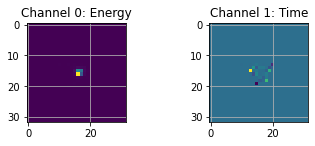

In [ ]:
plt.figure(1)

plt.subplot(221)
plt.imshow(X_train[1,0,:,:])
plt.title("Channel 0: Energy")  # Energy
plt.grid(True)

plt.subplot(222)
plt.imshow(X_train[1,1,:,:])
plt.title("Channel 1: Time")  # Time
plt.grid(True)


plt.show()

# Define dataset, data loaders and data generators

In [ ]:
import torch
from torch.utils import data

class Dataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, inputs, labels):
        'Initialization'
        self.labels = labels
        self.inputs = inputs

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.inputs)

  def __getitem__(self, index):
        'Generates one sample of data'

        # Get data and get label
        X = self.inputs[index]
        y = self.labels[index]

        return X, y

In [ ]:

train_loader = torch.utils.data.DataLoader(dataset={'input':X_train,'output':y_train},
                                          batch_size=1024,
                                          shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset={'input':X_valid,'output':y_valid})

test_loader = torch.utils.data.DataLoader(dataset={'input':X_test},
                                          batch_size=1024,
                                          shuffle=False)

# Define CNN Model
## This is a sample model. You can experiment with the model and try various architectures and other models to achieve the highest possible performance.  

In [ ]:
window_height=32
window_width=32

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        self.fc1 = nn.Linear(8*8*128, 2048)
        self.fc2 = nn.Linear(2048, 1)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = F.leaky_relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x


net = Net()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    net.cuda()
summary(net, (1, 32, 32), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
         MaxPool2d-2           [-1, 64, 16, 16]               0
            Conv2d-3          [-1, 128, 16, 16]          73,856
         MaxPool2d-4            [-1, 128, 8, 8]               0
            Linear-5                 [-1, 2048]      16,779,264
            Linear-6                    [-1, 1]           2,049
Total params: 16,855,809
Trainable params: 16,855,809
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.95
Params size (MB): 64.30
Estimated Total Size (MB): 65.26
----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
batch_size=1024
import torch
from torch.utils import data
#import cudnn
#from my_classes import Dataset


# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
#cudnn.benchmark = True

# Parameters
params = {'batch_size': batch_size,
          'shuffle': True,
          }
max_epochs = 100

# Generators
training_set = Dataset(X_train, y_train)
training_generator = data.DataLoader(training_set, **params)

validation_set = Dataset(X_valid, y_valid)
validation_generator = data.DataLoader(validation_set, **params)

In [ ]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

## Train the Model
### You may further optimize the model, tune hyper-parameters, etc. accordingly to achieve the best performance possible.

In [ ]:
num_epochs=20
correct=0
total=0
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(training_generator):   # Load a batch of images with its (index, data, class)
        #images = Variable(images.view(-1, 28*28))         # Convert torch tensor to Variable: change image from a vector of size 784 to a matrix of 28 x 28
        #labels = Variable(labels)
        if use_cuda and torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        optimizer.zero_grad()                             # Intialize the hidden weight to all zeros
        outputs = net(inputs[:,:1,:,:])                   #Using energy channel only with idx=0
                                      # Forward pass: compute the output class given a image
        loss = criterion(outputs[:,0], labels)                 # Compute the loss: difference between the output class and the pre-given label
        loss.backward()                                   # Backward pass: compute the weight
        optimizer.step()                                  # Optimizer: update the weights of hidden nodes
        outputs[outputs>0.5]=1
        outputs[outputs<0.5]=0
        total += labels.shape[0]
                                        # Increment the total count
        correct += (outputs[:,0] == labels).sum()
        
        if (i+1) % 2 == 0:                              # Logging
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Accuracy: %.4f'
                 %(epoch+1, num_epochs, i+1, len(X_train)//batch_size, loss.item(), ((100 * correct.item() / total))))
    #outputs = net(X_valid0.cuda())                             # Forward pass: compute the output class given a image
    #loss = criterion(outputs, Y_valid.cuda())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/20], Step [2/2], Loss: 1.5701, Accuracy: 49.3164
Epoch [2/20], Step [2/2], Loss: 0.7162, Accuracy: 49.6582
Epoch [3/20], Step [2/2], Loss: 0.6954, Accuracy: 49.7721
Epoch [4/20], Step [2/2], Loss: 0.8442, Accuracy: 49.8291
Epoch [5/20], Step [2/2], Loss: 0.7150, Accuracy: 49.8633
Epoch [6/20], Step [2/2], Loss: 0.6977, Accuracy: 49.8861
Epoch [7/20], Step [2/2], Loss: 0.6923, Accuracy: 49.9023
Epoch [8/20], Step [2/2], Loss: 0.6933, Accuracy: 49.9146
Epoch [9/20], Step [2/2], Loss: 0.6947, Accuracy: 49.9240
Epoch [10/20], Step [2/2], Loss: 0.6927, Accuracy: 49.9316
Epoch [11/20], Step [2/2], Loss: 0.6928, Accuracy: 49.9423
Epoch [12/20], Step [2/2], Loss: 0.6925, Accuracy: 50.6470
Epoch [13/20], Step [2/2], Loss: 0.6923, Accuracy: 50.5972
Epoch [14/20], Step [2/2], Loss: 0.6925, Accuracy: 50.5545
Epoch [15/20], Step [2/2], Loss: 0.6925, Accuracy: 50.5176
Epoch [16/20], Step [2/2], Loss: 0.6918, Accuracy: 50.7263
Epoch [17/20], Step [2/2], Loss: 0.6920, Accuracy: 50.9565
Epoch 

## Evaluate the Model  
### Along with the model accuracy, the prefered metric for evaluation is ROC (Receiver Operating Characteristic) curve and the AUC score (Area under the ROC Curve).

In [ ]:
net.eval()

Net(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1, bias=True)
)

In [ ]:
from sklearn.metrics import roc_curve, auc
for i,(inputs,labels) in enumerate(validation_generator):
  inputs=inputs.cuda()
  labels=labels.cuda()
  if i==0:
    pred = torch.Tensor.cpu(net(inputs[:,0:1,:,:]))
    true_vals = torch.Tensor.cpu(labels)
    continue
  pred = torch.cat((pred,torch.Tensor.cpu(net(inputs[:,0:1,:,:]))))
  true_vals=torch.cat((true_vals,torch.Tensor.cpu(labels)))
  
y_pred = pred.detach().numpy().ravel()
true_vals = true_vals.detach().numpy()
fpr, tpr, thresholds = roc_curve(true_vals, y_pred)
auc_score = auc(fpr, tpr)
print(auc_score)

0.5983519554138184


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


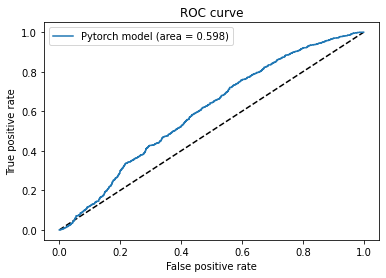

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Pytorch model (area = {:.3f})'.format(auc_score))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Submission format: 
### Please submit the Google Colab Jupyter Notebook demonstrating your solution in the similar format as illustrated in this notebook. It should contain :
*   The final model architecture, parameters and hyper-parameters yielding the best possible performance,
*   Its Training and Validation accuracy, 
*   ROC curve and the AUC score as shown above.
*   Also, please submit the final trained model containing the model architecture and its trained weights along with this notebook (For example: HDF5 file, .pb file, .pt file, etc.). You are free to choose Machine Learning Framework of your choice. 